# Unsupervised Anomaly Detection for Vehicle Claims Dataset

# 1. Introduction
Anomaly detection is the process of identifying abnormal activities/patterns in a dataset. Anomalous data are found in bank activities, insurance, law and regulations, health care, and more.
There are three main classes for anomaly detection techniques supervised learning, semi-supervised learning, and unsupervised learning. The choice depends on the dataset whether it is a labeled dataset or an unlabeled dataset. In this project, we explore the Vehicle Claims dataset introduced by (Chawda et al., 2022) It consists of fraudulent insurance claims for automotive repairs. Insurance claims can be identified as an anomaly if it amounts to the sum of repairing an engine when in fact the claim issue is fixing a tire. We will analyze the data and perform label encoding on the categorical data types. Further, we will train the data using Isolation Forest and autoencoder unsupervised learning techniques to predict the outliers.

# 2. Methodology

## 2.1 Dataset
The dataset used in this project was retrieved from recent work (Chawda et al., 2022). The dataset consists of 25 columns and 268255 records, 56749 of which are anomalous points. They replaced missing values with anomalous points because they believed it will be useful for explainable models to determine the cell values due to which the data point behaves as an anomaly.

## 2.2 Data Preprocessing

### 2.2.1 Data Tools
The tools used in this project are:
*   Google Colab is a tool that allows us to write and execute python code through the browser.
*   Dask is an open-source Python library for parallel computing.

### 2.2.2 Data Cleaning
For data cleaning we dropped unnecessary columns which are Genmodel_ID, Adv_year, Adv_month, Adv_day, category_anomaly.

### 2.2.3 Lebel Encoding
Label encoding is the process of converting each categorical feature into a numerical value. We performed label encoding in each categorical column in the dataset.

In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
client = Client(threads_per_worker=4,n_workers=4,memory_limit='4GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35519,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:39925,Total threads: 4
Dashboard: http://127.0.0.1:38011/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:35127,


In [4]:
cliams_data = dd.read_csv("/content/drive/My Drive/Colab Notebooks/vehicle_claims/vehicle_claims_labeled.csv")

In [5]:
cliams_data = cliams_data.compute()

In [6]:
cliams_data.shape

(268255, 25)

In [7]:
cliams_data.head()

,Maker,Genmodel,Genmodel_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,...,issue,issue_id,Adv_day,breakdown_date,repair_complexity,repair_cost,repair_hours,Label,category_anomaly,repair_date
0,Bentley,Arnage,10_1,2018,4,Silver,2000.0,Saloon,60000,6.8L,...,Starter Motor Issue,0,19,2018-04-19,3,395.000,9.0,0,0,2018-04-21
1,Bentley,Arnage,10_1,2018,6,Grey,2002.0,Saloon,44000,6.8L,...,Radiator Leaking,0,15,2018-06-15,3,695.000,6.0,0,0,2018-06-16
2,Bentley,Arnage,10_1,2017,11,Blue,2002.0,Saloon,55000,6.8L,...,Steering Wheel Shaking,0,10,2017-11-10,3,89.999,3.0,0,0,2017-11-10
3,Bentley,Arnage,10_1,2018,4,Green,2003.0,Saloon,14000,6.8L,...,Electrical Issue,4,14,2018-04-14,3,224.844,6.0,0,0,2018-04-15
4,Bentley,Arnage,10_1,2017,11,Grey,2003.0,Saloon,61652,6.8L,...,Windscreen Crack,0,6,2017-11-06,3,75.933,3.0,0,0,2017-11-06


In [8]:
cliams_data.groupby('Label')[["Label"]].count()

,Label
Label,
0,211506
1,56749


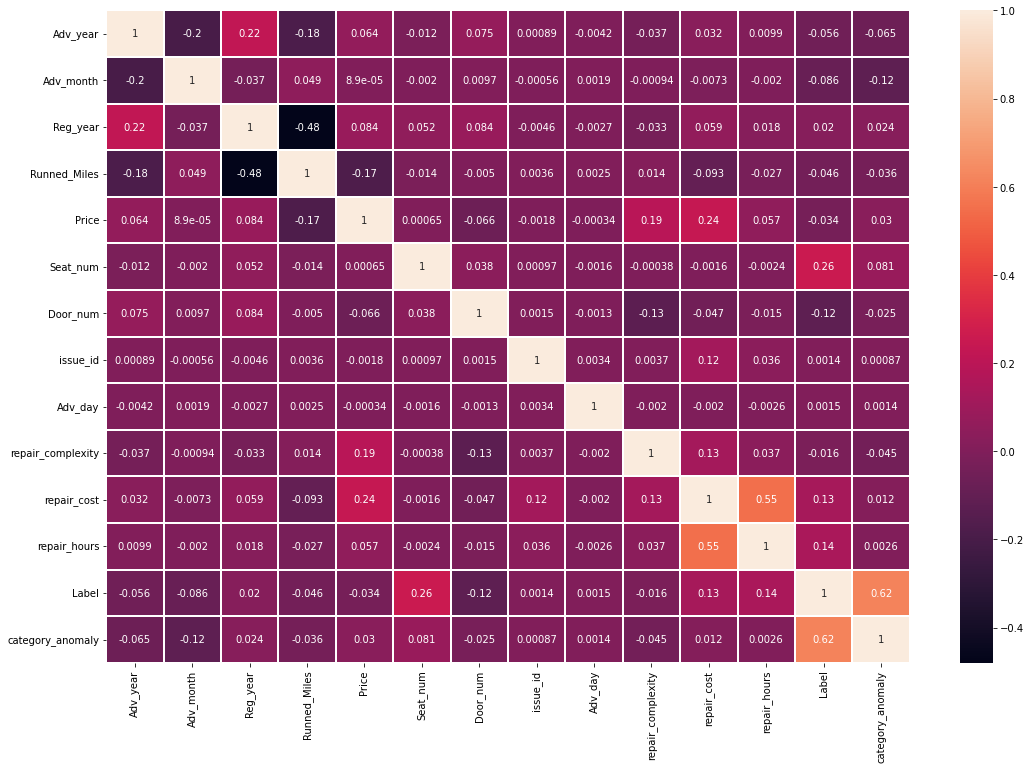

In [9]:
plt.figure(figsize = (18, 12))

corr = cliams_data.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [10]:
cliams_data_unlabeled = cliams_data.drop([' Genmodel_ID','Adv_year', 'Adv_month',
                                     'Adv_day','Label', 
                                     'category_anomaly'], axis=1)

In [11]:
cliams_data_unlabeled.isna().sum()

Maker                0
 Genmodel            0
Color                0
Reg_year             0
Bodytype             0
Runned_Miles         0
Engin_size           0
Gearbox              0
Fuel_type            0
Price                0
Seat_num             0
Door_num             0
issue                0
issue_id             0
breakdown_date       0
repair_complexity    0
repair_cost          0
repair_hours         0
repair_date          0
dtype: int64

In [12]:
cliams_data_unlabeled.head()

,Maker,Genmodel,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Price,Seat_num,Door_num,issue,issue_id,breakdown_date,repair_complexity,repair_cost,repair_hours,repair_date
0,Bentley,Arnage,Silver,2000.0,Saloon,60000,6.8L,Automatic,Petrol,21500.0,5.0,4.0,Starter Motor Issue,0,2018-04-19,3,395.000,9.0,2018-04-21
1,Bentley,Arnage,Grey,2002.0,Saloon,44000,6.8L,Automatic,Petrol,28750.0,5.0,4.0,Radiator Leaking,0,2018-06-15,3,695.000,6.0,2018-06-16
2,Bentley,Arnage,Blue,2002.0,Saloon,55000,6.8L,Automatic,Petrol,29999.0,5.0,4.0,Steering Wheel Shaking,0,2017-11-10,3,89.999,3.0,2017-11-10
3,Bentley,Arnage,Green,2003.0,Saloon,14000,6.8L,Automatic,Petrol,34948.0,5.0,4.0,Electrical Issue,4,2018-04-14,3,224.844,6.0,2018-04-15
4,Bentley,Arnage,Grey,2003.0,Saloon,61652,6.8L,Automatic,Petrol,26555.0,5.0,4.0,Windscreen Crack,0,2017-11-06,3,75.933,3.0,2017-11-06


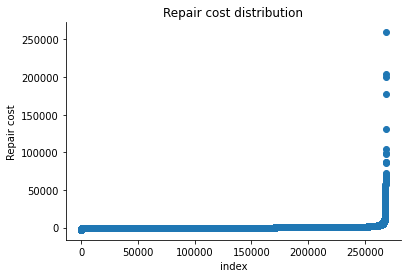

In [13]:
#Repair cost distribution over the dataset shape
plt.scatter(range(cliams_data_unlabeled.shape[0]), np.sort(cliams_data_unlabeled['repair_cost'].values))
plt.xlabel('index')
plt.ylabel('Repair cost')
plt.title("Repair cost distribution")
sns.despine()

In [ ]:
!pip3 install dask_ml

In [15]:
from dask_ml import preprocessing

In [16]:
#label encoding
for col in cliams_data_unlabeled.columns:
  if cliams_data_unlabeled[col].dtype == "object":
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(list(cliams_data_unlabeled[col].astype(str).values))
    cliams_data_unlabeled[col] = label_encoder.transform(list(cliams_data_unlabeled[col].astype(str).values))

In [17]:
#label encoding
for col in cliams_data.columns:
  if cliams_data[col].dtype == "object":
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(list(cliams_data[col].astype(str).values))
    cliams_data[col] = label_encoder.transform(list(cliams_data[col].astype(str).values))

# 3. Results

## 3.1 Isolation Forest
Isolation forest is an unsupervised learning technique built on an ensemble of binary isolation trees that identifies abnormal observations by randomly selecting a feature.

In this model, we set the proportion of outliers in the dataset
(contamination) to 0.01 and the number of estimators to 1000. The dataset was not split in this experiment. The whole dataset was used for training and testing.

The accuracy of the model prediction was 79%. It predicted 210697 normal classes out of 211506 and 54875 anomalies out of 56749

In [18]:
#contamination is used to define the threshold on the scores of the samples. (it should be in the range (0, 0.5])
contamination = 0.01

In [19]:
%%time
model = IsolationForest(contamination=contamination, n_estimators=1000)
model.fit(cliams_data_unlabeled)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


CPU times: user 2min 28s, sys: 4.3 s, total: 2min 33s
Wall time: 2min 45s


IsolationForest(contamination=0.01, n_estimators=1000)

In [20]:
cliams_data_unlabeled["iforest"] = pd.Series(model.predict(cliams_data_unlabeled))
cliams_data_unlabeled["iforest"] = cliams_data_unlabeled["iforest"].map({1: 0, -1: 1})
print(cliams_data_unlabeled["iforest"].value_counts())

0    265572
1      2683
Name: iforest, dtype: int64


In [21]:
print('CONFUSION MATRIX:\n', confusion_matrix(cliams_data['Label'],cliams_data_unlabeled["iforest"]))
print("\nClassification Report:\n", classification_report(cliams_data['Label'], cliams_data_unlabeled["iforest"]))

CONFUSION MATRIX:
 [[210689    817]
 [ 54883   1866]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88    211506
           1       0.70      0.03      0.06     56749

    accuracy                           0.79    268255
   macro avg       0.74      0.51      0.47    268255
weighted avg       0.77      0.79      0.71    268255



## 3.2 AutoEncoders
Auto-Encoders are unsupervised neural networks. They consist of two main layers encoder layer and the decoder layer. The encoder layer takes input and learns to encode that data into code. The decoder layer reconstructs the encoded data and creates an output (similar to the original data). This process can remove noise from the original data and allow us to detect abnormal status hence the anomaly detection. Autoencoder uses only normal data to train the model and all data to make predictions. Therefore, we expect outliers to have higher reconstruction errors because they are different from the regular data.

In this model, we split the data into training and testing with 20% for the test size. Then created an encoder layer with 4 dense layers with a relu activation function and a decoder layer with also 4 dense layers with relu activation and the last layer with a sigmoid function. Activation function applies a non-linear transformation to the output from a layer. After that, we set a threshold based on percentile to identify outliers using 98% loss to identify 2% of the data as outliers.

The accuracy of the model prediction was 78%. It predicted 41647 normal classes out of 42328 and 10930 anomalies out of 11323

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    cliams_data, cliams_data['Label'], test_size=0.2, random_state=42)

In [23]:
cliams_data.shape

(268255, 25)

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, losses

In [25]:
# take only normal data for the training dataset
X_train_normal = X_train[y_train == 0]

input = tf.keras.layers.Input(shape=(25,))

encoder = tf.keras.Sequential([
  layers.Dense(16, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(4, activation='relu'),
  layers.Dense(2, activation='relu')])(input)

decoder = tf.keras.Sequential([
      layers.Dense(4, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(25, activation="sigmoid")])(encoder)

# model creation
autoencoder = tf.keras.Model(inputs=input, outputs=decoder)

In [26]:
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(X_train_normal, X_train_normal, 
          epochs=20, 
          batch_size=64,
          validation_data=(X_test, X_test),
          shuffle=True)

Epoch 1/20
2644/2644 [==============================] - 10s 3ms/step - loss: 2806.2363 - val_loss: 2854.6038
Epoch 2/20
2644/2644 [==============================] - 8s 3ms/step - loss: 2806.2327 - val_loss: 2854.6038
Epoch 3/20
2644/2644 [==============================] - 10s 4ms/step - loss: 2806.2314 - val_loss: 2854.6038
Epoch 4/20
2644/2644 [==============================] - 8s 3ms/step - loss: 2806.2310 - val_loss: 2854.6038
Epoch 5/20
2644/2644 [==============================] - 7s 3ms/step - loss: 2806.2351 - val_loss: 2854.6038
Epoch 6/20
2644/2644 [==============================] - 7s 3ms/step - loss: 2806.2273 - val_loss: 2854.6038
Epoch 7/20
2644/2644 [==============================] - 9s 4ms/step - loss: 2806.2349 - val_loss: 2854.6038
Epoch 8/20
2644/2644 [==============================] - 9s 3ms/step - loss: 2806.2278 - val_loss: 2854.6038
Epoch 9/20
2644/2644 [==============================] - 9s 3ms/step - loss: 2806.2314 - val_loss: 2854.6038
Epoch 10/20
2644/2644 [===

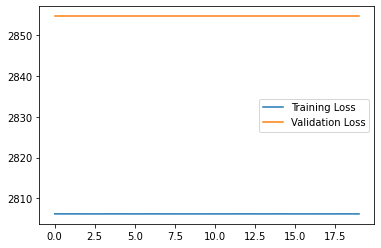

In [27]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [28]:
prediction = autoencoder.predict(X_test)

# Get the mean absolute error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mae(prediction, X_test)

# Check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)
print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')

1677/1677 [==============================] - 3s 2ms/step
The prediction loss threshold for 2% of outliers is 6543.90


In [29]:
# Check the model performance at 2% threshold
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]

# prediction performance
print('CONFUSION MATRIX:\n', confusion_matrix(y_test, threshold_prediction))

print("\nClassification Report:\n", classification_report(y_test, threshold_prediction))

CONFUSION MATRIX:
 [[41647   681]
 [10930   393]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.88     42328
           1       0.37      0.03      0.06     11323

    accuracy                           0.78     53651
   macro avg       0.58      0.51      0.47     53651
weighted avg       0.70      0.78      0.71     53651



# 4. Conclusion

In this project, we performed an unsupervised learning technique on the vehicle claims dataset to predict outliers using Isolation Forest and Autoencoders. We learned how to encode categorical data types using a label encoder. Both models performed relatively close and gave 79% and 78% accuracy using Isolation Forest and Autoencoders respectively. Although, the Autoencoders were predicted on 20% of the total data, unlike Isolation Forest.

In future work, we suggest using a one-hot encoding technique and comparing the result with the use of a label encoder.

# 5. References 
Chawda, A., Grimm, S., & Kloft, M. (2022). Unsupervised Anomaly Detection for Auditing Data and Impact of Categorical Encodings. http://arxiv.org/abs/2210.14056